In [1]:
import numpy as np
import pandas as pd
import pymysql
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import sys

In [30]:
%matplotlib inline

In [4]:
connection = pymysql.connect(host='localhost', user='root', password='Sk1ttles', db='nba_stats_prod')

In [7]:
player_pred_sql = """
       select pred.player_id,
       pred.name,
       pred.team,
       pred.game_date,
       points.pts,
       points.flag
from nba_stats_prod.player_prediction_results as pred
inner join nba_stats_prod.box_scores_map_view as map on ( (pred.team = map.team) and (str_to_date(pred.game_date, '%Y-%m-%d') = map.game_date) )
inner join (

    select player_id, game_date, pts, 'predicted' as flag
    from nba_stats_prod.player_prediction_results

    union

    select b.player_id, m.game_date, b.pts, 'actual' as flag
    from nba_stats_prod.basic_box_stats as b
    inner join box_scores_map_view as m on b.game_hash = m.game_hash

    ) as points on pred.player_id = points.player_id and map.game_date = points.game_date"""

In [8]:
player_pred_df = pd.read_sql(sql=player_pred_sql, con=connection, index_col=None)

In [9]:
player_pred_df.groupby(['team', 'game_date'])

In [10]:
sns.set_style('whitegrid')

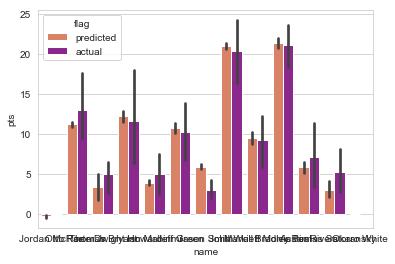

In [11]:
sns.barplot(x='name', y='pts', data=player_pred_df[player_pred_df['team'] == 'Washington Wizards'], hue='flag', palette='plasma_r')

In [12]:
### Pie chart of win and lose percentage for team in question

In [36]:
labels = 'lose_prob', 'win_prob'
content = pd.read_sql(sql='select lose_probability, win_probability from win_predictions_comparison_view where team like \'Los Angeles Lakers\'', con=connection, index_col=None).iloc[0]

In [37]:
content

lose_probability    0.375706
win_probability     0.624294
Name: 0, dtype: float64

In [14]:
colors = ['red', 'green']
explode = (.2, 0)

([<matplotlib.patches.Wedge at 0x116927c50>,
 [Text(-1.15178,-0.602829,'lose_prob'), Text(0.974583,0.510086,'win_prob')],
 [Text(-0.708788,-0.370972,'37.57059872150%'),
  Text(0.531591,0.278229,'62.42939829826%')])

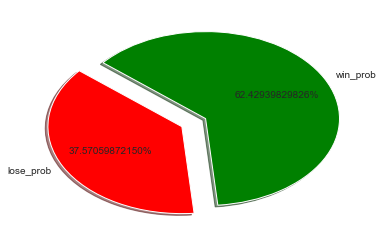

In [15]:
plt.pie(content, explode=explode, labels=labels, colors=colors,
        autopct='%1.11f%%', shadow=True, startangle=140)

In [16]:
### plotting r-squared over game_dates

In [17]:
sql = 'select * from total_points_predictions'

In [18]:
r_squared = pd.read_sql(sql=sql, con=connection, index_col=None)

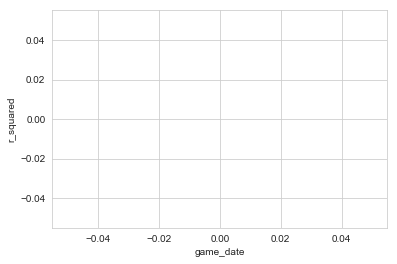

In [19]:
sns.lineplot(x='game_date', y='predicted_total_pts', data=r_squared[r_squared['team'] == 'Toronto'], color='red', legend='brief')
sns.lineplot(x='game_date', y='r_squared', data=r_squared[r_squared['team'] == 'Toronto'], color='blue', legend='brief')


In [20]:
### Total score comparison report ###

In [21]:
sql = 'select * from vis_total_points_comparision where team like \'Washington%\''

In [22]:
total_pts_df = pd.read_sql(sql=sql, con=connection, index_col=None)

In [23]:
total_pts_df.groupby(['team', 'game_date'])

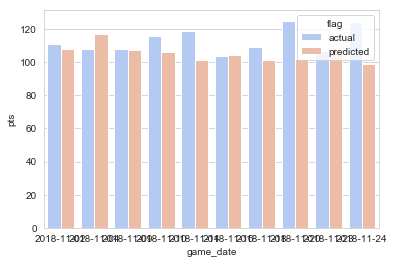

In [24]:
sns.barplot(x='game_date', y='pts', data=total_pts_df, hue='flag', palette='coolwarm')

In [ ]:
####Lasso Reg accuracy by teams

In [60]:
sql = """

select preds.game_hash,
       preds.team,
       preds.win_probability,
       preds.lose_probability,
       preds.team_score,
       preds.opp_score,
       (case
          when (preds.win_probability > preds.lose_probability and preds.team_score > preds.opp_score) then 1
          when (preds.lose_probability > preds.win_probability and preds.opp_score > preds.team_score) then 1
        else 0 end) as flag
from win_predictions_comparison_view as preds
where preds.game_date > str_to_date('11-17-2018', '%m-%d-%Y');

"""

In [61]:
train_df = pd.read_sql(sql=sql, con=connection, index_col=None)

In [62]:
colors = ['red', 'green']
explode = (.2, 0)
labels = 'incorrect_pct', 'correct_pct'

In [66]:
content = np.array([len(train_df[train_df['flag'] == 0]), len(train_df[train_df['flag'] == 1])])
content

array([35, 57])

([<matplotlib.patches.Wedge at 0x1175f1390>,
 [Text(-1.1427,-0.619873,'incorrect_pct'),
  Text(0.966898,0.524508,'correct_pct')],
 [Text(-0.703198,-0.38146,'38.04%'), Text(0.527399,0.286095,'61.96%')])

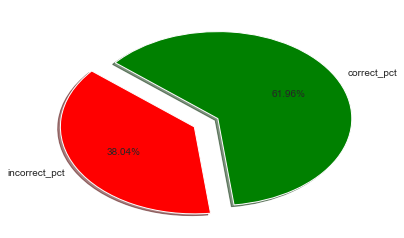

In [67]:
plt.pie(content, explode=explode, labels=labels, colors=colors,
        autopct='%1.2f%%', shadow=True, startangle=140)

In [33]:
### checking the accuracy of the players predicter

In [65]:
sql = """

select preds.game_hash,
       preds.team,
       preds.win_probability,
       preds.lose_probability,
       preds.team_score,
       preds.opp_score,

       (case
          when (preds.team_score > preds.opp_score and preds.win_probability > preds.lose_probability) then 1
          when (preds.opp_score > preds.team_score and preds.lose_probability > preds.win_probability) then 1
        else 0 end) as flag

from win_predictions_comparison_view as preds
inner join box_score_map as map on preds.game_hash = map.game_hash
where map.game_date >= str_to_date('11/17/2018', '%m/%d/%Y');

"""

In [68]:
train_df = pd.read_sql(sql=sql, con=connection, index_col=None)

In [69]:
content = np.array([len(train_df[train_df['flag'] == 0]), len(train_df[train_df['flag'] == 1])])

([<matplotlib.patches.Wedge at 0x117628d30>,
 [Text(-1.11764,-0.663984,'incorrect_pct'),
  Text(0.945697,0.561833,'correct_pct')],
 [Text(-0.68778,-0.408606,'39.29%'), Text(0.515835,0.306454,'60.71%')])

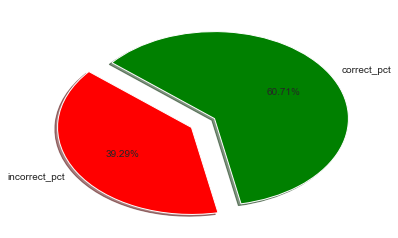

In [70]:
plt.pie(content, explode=explode, labels=labels, colors=colors,
        autopct='%1.2f%%', shadow=True, startangle=140)

In [71]:
### checking players scores predcitor

In [88]:
sql= """

select preds.player_id,
       preds.name,
       preds.team,
       preds.game_date,
       preds.predicted_points,
       preds.actual_points,

       (case
           when (abs(preds.predicted_points - preds.actual_points) <= 7) then 1
        else 0 end) as flag
from player_predictions_comparison_view as preds

"""

In [89]:
train_df = pd.read_sql(sql=sql, con=connection, index_col=None)

In [90]:
colors = ['red', 'green']
explode = (.2, 0)
labels = 'incorrect_pct', 'correct_pct'

In [91]:
content = np.array([len(train_df[train_df['flag'] == 0]), len(train_df[train_df['flag'] == 1])])

([<matplotlib.patches.Wedge at 0x117a47cc0>,
 [Text(-1.29875,0.0569927,'incorrect_pct'),
  Text(1.09894,-0.0482246,'correct_pct')],
 [Text(-0.799231,0.0350725,'20.83%'), Text(0.599423,-0.0263043,'79.17%')])

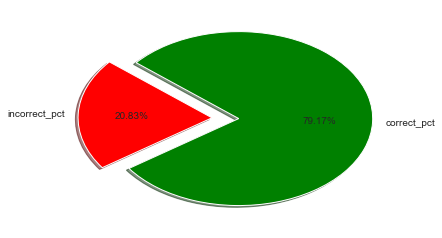

In [92]:
plt.pie(content, explode=explode, labels=labels, colors=colors,
        autopct='%1.2f%%', shadow=True, startangle=140)